In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import scipy
import numpy as np
import matplotlib.pyplot as plt

import celeri

plt.rcParams["text.usetex"] = False

# KL functions

In [3]:
def get_index(assembly, segment, station, block, meshes, mogi):
    # Create dictionary to store indices and sizes for operator building
    index = addict.Dict()
    index.n_blocks = len(block)
    index.n_segments = len(segment)
    index.n_stations = assembly.data.n_stations
    index.n_meshes = len(meshes)
    index.n_mogis = len(mogi)
    index.vertical_velocities = np.arange(2, 3 * index.n_stations, 3)
    index.n_block_constraints = assembly.data.n_block_constraints
    index.station_row_keep_index = celeri.get_keep_index_12(3 * index.n_stations)
    index.start_station_row = 0
    index.end_station_row = 2 * index.n_stations
    index.start_block_col = 0
    index.end_block_col = 3 * index.n_blocks
    index.start_block_constraints_row = index.end_station_row
    index.end_block_constraints_row = (
        index.start_block_constraints_row + 3 * index.n_block_constraints
    )
    index.n_slip_rate_constraints = assembly.data.slip_rate_constraints.size
    index.start_slip_rate_constraints_row = index.end_block_constraints_row
    index.end_slip_rate_constraints_row = (
        index.start_slip_rate_constraints_row + index.n_slip_rate_constraints
    )
    index.n_tde_total = 0
    index.n_tde_constraints_total = 0

    # A bunch of declarations of TDE-related indices as arrays, otherwise they're dicts
    index.n_tde = np.zeros(index.n_meshes, dtype=int)
    index.n_tde_constraints = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_col = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_col = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_smoothing_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_smoothing_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_top_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_top_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_bot_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_bot_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_side_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_side_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_coup_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_coup_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ss_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ss_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ds_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ds_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)

    for i in range(index.n_meshes):
        index.n_tde[i] = meshes[i].n_tde
        index.n_tde_total += index.n_tde[i]
        index.n_tde_constraints[i] = meshes[i].n_tde_constraints
        index.n_tde_constraints_total += index.n_tde_constraints[i]
        if i == 0:
            index.start_tde_col[i] = index.end_block_col
            index.end_tde_col[i] = index.start_tde_col[i] + 2 * index.n_tde[i]
            index.start_tde_smoothing_row[i] = index.end_slip_rate_constraints_row
            index.end_tde_smoothing_row[i] = (
                index.start_tde_smoothing_row[i] + 2 * index.n_tde[i]
            )
            index.start_tde_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_constraint_row[i] = (
                index.start_tde_constraint_row[i] + index.n_tde_constraints[i]
            )
            index.start_tde_top_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_top_constraint_row[i] = index.start_tde_top_constraint_row[
                i
            ] + len(meshes[i].top_slip_idx)
            index.start_tde_bot_constraint_row[i] = index.end_tde_top_constraint_row[i]
            index.end_tde_bot_constraint_row[i] = index.start_tde_bot_constraint_row[
                i
            ] + len(meshes[i].bot_slip_idx)
            index.start_tde_side_constraint_row[i] = index.end_tde_bot_constraint_row[i]
            index.end_tde_side_constraint_row[i] = index.start_tde_side_constraint_row[
                i
            ] + len(meshes[i].side_slip_idx)
            index.start_tde_coup_constraint_row[i] = index.end_tde_side_constraint_row[
                i
            ]
            index.end_tde_coup_constraint_row[i] = index.start_tde_coup_constraint_row[
                i
            ] + len(meshes[i].coup_idx)
            index.start_tde_ss_slip_constraint_row[i] = (
                index.end_tde_coup_constraint_row[i]
            )
            index.end_tde_ss_slip_constraint_row[i] = (
                index.start_tde_ss_slip_constraint_row[i] + len(meshes[i].ss_slip_idx)
            )
            index.start_tde_ds_slip_constraint_row[i] = (
                index.end_tde_ss_slip_constraint_row[i]
            )
            index.end_tde_ds_slip_constraint_row[i] = (
                index.start_tde_ds_slip_constraint_row[i] + len(meshes[i].ds_slip_idx)
            )
        else:
            index.start_tde_col[i] = index.end_tde_col[i - 1]
            index.end_tde_col[i] = index.start_tde_col[i] + 2 * index.n_tde[i]
            index.start_tde_smoothing_row[i] = index.end_tde_constraint_row[i - 1]
            index.end_tde_smoothing_row[i] = (
                index.start_tde_smoothing_row[i] + 2 * index.n_tde[i]
            )
            index.start_tde_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_constraint_row[i] = (
                index.start_tde_constraint_row[i] + index.n_tde_constraints[i]
            )
            index.start_tde_top_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_top_constraint_row[i] = index.start_tde_top_constraint_row[
                i
            ] + len(meshes[i].top_slip_idx)
            index.start_tde_bot_constraint_row[i] = index.end_tde_top_constraint_row[i]
            index.end_tde_bot_constraint_row[i] = index.start_tde_bot_constraint_row[
                i
            ] + len(meshes[i].bot_slip_idx)
            index.start_tde_side_constraint_row[i] = index.end_tde_bot_constraint_row[i]
            index.end_tde_side_constraint_row[i] = index.start_tde_side_constraint_row[
                i
            ] + len(meshes[i].side_slip_idx)
            index.start_tde_coup_constraint_row[i] = index.end_tde_side_constraint_row[
                i
            ]
            index.end_tde_coup_constraint_row[i] = index.start_tde_coup_constraint_row[
                i
            ] + len(meshes[i].coup_idx)
            index.start_tde_ss_slip_constraint_row[i] = (
                index.end_tde_coup_constraint_row[i]
            )
            index.end_tde_ss_slip_constraint_row[i] = (
                index.start_tde_ss_slip_constraint_row[i] + len(meshes[i].ss_slip_idx)
            )
            index.start_tde_ds_slip_constraint_row[i] = (
                index.end_tde_ss_slip_constraint_row[i]
            )
            index.end_tde_ds_slip_constraint_row[i] = (
                index.start_tde_ds_slip_constraint_row[i] + len(meshes[i].ds_slip_idx)
            )

    # EIGEN: Get total number of eigenmodes
    index.n_eigen_total = 0
    for i in range(index.n_meshes):
        index.n_eigen_total += meshes[i].n_modes_strike_slip
        index.n_eigen_total += meshes[i].n_modes_dip_slip
    print(f"{index.n_eigen_total=}")

    # EIGEN: Count eigenmodes for each mesh
    index.n_modes_mesh = np.zeros(index.n_meshes, dtype=int)
    for i in range(index.n_meshes):
        index.n_modes_mesh[i] = (
            meshes[i].n_modes_strike_slip + meshes[i].n_modes_dip_slip
        )
        print(f"{index.n_modes_mesh[i]=}")

    # EIGEN: Column and row indices
    index.start_col_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_col_eigen = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ss_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ss_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ds_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ds_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)

    # EIGEN: columns and rows for eigenmodes to velocity
    for i in range(index.n_meshes):
        # First mesh
        if i == 0:
            # Locations for eigenmodes to velocities
            index.start_col_eigen[i] = 3 * index.n_blocks
            index.end_col_eigen[i] = index.start_col_eigen[i] + index.n_modes_mesh[i]
            index.start_tde_row_eigen[i] = 0
            index.end_row_eigen[i] = 2 * index.n_stations

        # Meshes after first mesh
        else:
            # Locations for eigenmodes to velocities
            index.start_col_eigen[i] = index.end_col_eigen[i - 1]
            index.end_col_eigen[i] = index.start_col_eigen[i] + index.n_modes_mesh[i]
            index.start_tde_row_eigen[i] = 0
            index.end_row_eigen[i] = 2 * index.n_stations

    # EIGEN: Set initial values to follow segment slip rate constraints
    index.start_tde_constraint_row_eigen[0] = index.end_slip_rate_constraints_row
    index.end_tde_constraint_row_eigen[0] = (
        index.start_tde_constraint_row_eigen[0] + index.n_tde_constraints[i]
    )
    index.start_tde_ss_slip_constraint_row_eigen[0] = (
        index.end_slip_rate_constraints_row
    )
    index.end_tde_ss_slip_constraint_row_eigen[0] = (
        index.start_tde_ss_slip_constraint_row_eigen[0] + index.n_tde_constraints[i]
    )
    index.start_tde_ds_slip_constraint_row_eigen[0] = (
        index.end_tde_ss_slip_constraint_row_eigen[0]
    )
    index.end_tde_ds_slip_constraint_row_eigen[0] = (
        index.start_tde_ds_slip_constraint_row_eigen[0] + index.n_tde_constraints[i]
    )

    # EIGEN: Rows for eigen to TDE boundary conditions
    for i in range(1, index.n_meshes):
        # All constraints for eigen to constraint matrix
        index.start_tde_constraint_row_eigen[i] = index.end_tde_constraint_row_eigen[
            i - 1
        ]
        index.end_tde_constraint_row_eigen[i] = (
            index.end_tde_constraint_row_eigen[i - 1] + index.n_tde_constraints[i]
        )

        # Strike-slip (ss) constraints for data vector
        # NOTE: Assuming panel structure rather than checkerboard
        # NOTE: NOT SURE THIS IS TRUE.  CHECK EIGEN TO BC OPERATOR
        index.start_tde_ss_slip_constraint_row_eigen = (
            index.end_tde_ds_slip_constraint_row_eigen[i - 1]
        )
        index.end_tde_ss_slip_constraint_row_eigen = (
            index.end_tde_ds_slip_constraint_row_eigen[i - 1]
            + len(meshes[i].ss_slip_idx)
        )

        # Dip-slip (ds) constraints for data vector
        # NOTE: Assuming panel structure rather than checkerboard
        # NOTE: NOT SURE THIS IS TRUE.  CHECK EIGEN TO BC OPERATOR
        index.start_tde_ds_slip_constraint_row_eigen = (
            index.end_tde_ds_slip_constraint_row_eigen[i - 1]
        )
        index.end_tde_ds_slip_constraint_row_eigen = (
            index.end_tde_ds_slip_constraint_row_eigen[i - 1]
            + len(meshes[i].ds_slip_idx)
        )

    # EIGEN: Rows for QP bounds
    # Create index components for slip rate constraints
    index.qp_constraint_slip_rate_start_row_eigen = 0
    index.qp_constraint_slip_rate_end_row_eigen = 0

    # Create index components for liner inequality matrix and data vector
    index.qp_constraint_tde_rate_start_row_eigen = [None] * index.n_meshes
    index.qp_constraint_tde_rate_end_row_eigen = [None] * index.n_meshes

    # Set row indices for first mesh
    index.qp_constraint_tde_rate_start_row_eigen[0] = (
        index.qp_constraint_slip_rate_start_row_eigen
    )
    index.qp_constraint_tde_rate_end_row_eigen[0] = (
        index.qp_constraint_tde_rate_start_row_eigen[0] + 4 * index.n_tde[0]
    )

    for i in range(1, index.n_meshes):
        # Start row for current mesh
        index.qp_constraint_tde_rate_start_row_eigen[i] = (
            index.qp_constraint_slip_rate_end_row_eigen[i - 1]
        )

        # End row for current mesh
        index.qp_constraint_tde_rate_end_row_eigen[i] = (
            index.qp_constraint_tde_rate_start_row_eigen[i] + 4 * index.n_tde[i]
        )

    # Index for block strain
    index.n_strain_blocks = np.sum(block.strain_rate_flag)
    index.n_block_strain_components = 3 * index.n_strain_blocks
    index.start_block_strain_col = index.end_tde_col[-1]
    index.end_block_strain_col = (
        index.start_block_strain_col + index.n_block_strain_components
    )

    # Index for Mogi sources
    index.start_mogi_col = index.end_block_strain_col
    index.end_mogi_col = index.start_mogi_col + index.n_mogis

    index.n_operator_rows = (
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + 2 * index.n_tde_total
        + index.n_tde_constraints_total
    )
    index.n_operator_cols = (
        3 * index.n_blocks
        + 2 * index.n_tde_total
        + 3 * index.n_strain_blocks
        + index.n_mogis
    )

    # Total number of columns for eigenmode problem
    index.n_operator_cols_eigen = (
        3 * index.n_blocks
        + index.n_eigen_total
        + 3 * index.n_strain_blocks
        + index.n_mogis
    )

    # Total number of rows for eigenmode problem
    index.n_operator_rows_eigen = (
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Indices for QP hard slip rate bounds
    index.slip_rate_bounds = np.where(
        celeri.interleave3(
            segment.ss_rate_bound_flag,
            segment.ds_rate_bound_flag,
            segment.ts_rate_bound_flag,
        )
        == 1
    )[0]
    index.n_slip_rate_bounds = len(index.slip_rate_bounds)

    return index


def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z, distance_exponent):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-(distance_matrix**distance_exponent))

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


def get_data_vector_eigen(meshes, assembly, index):
    data_vector = np.zeros(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Add GPS stations to data vector
    data_vector[index.start_station_row : index.end_station_row] = celeri.interleave2(
        assembly.data.east_vel, assembly.data.north_vel
    )

    # Add block motion constraints to data vector
    data_vector[index.start_block_constraints_row : index.end_block_constraints_row] = (
        DEG_PER_MYR_TO_RAD_PER_YR * assembly.data.block_constraints
    )

    # Add slip rate constraints to data vector
    data_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = assembly.data.slip_rate_constraints

    # Add TDE boundary condtions constraints
    for i in range(index.n_meshes):
        data_vector[
            index.start_tde_ss_slip_constraint_row_eigen[
                i
            ] : index.end_tde_ss_slip_constraint_row_eigen[i]
        ] = meshes[i].ss_slip_constraint_rate

        data_vector[
            index.start_tde_ds_slip_constraint_row_eigen[
                i
            ] : index.end_tde_ds_slip_constraint_row_eigen[i]
        ] = meshes[i].ds_slip_constraint_rate
    return data_vector


def get_weighting_vector_eigen(command, station, meshes, index):
    # Initialize and build weighting matrix
    weighting_vector = np.ones(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    weighting_vector[index.start_station_row : index.end_station_row] = (
        celeri.interleave2(1 / (station.east_sig**2), 1 / (station.north_sig**2))
    )

    weighting_vector[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] = command.block_constraint_weight

    weighting_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

    for i in range(len(meshes)):
        # TODO: This is too hacky to keep.  Revise with no reference to smoothing
        weighting_vector[
            index.start_tde_constraint_row_eigen[
                i
            ] : index.end_tde_constraint_row_eigen[i]
        ] = command.tri_con_weight * np.ones(index.n_tde_constraints[i])

    return weighting_vector


def get_eigenvectors_to_tde_slip(operators, meshes):
    for i in range(len(meshes)):
        logger.info(f"Start: Eigenvectors to TDE slip for mesh: {meshes[i].file_name}")
        # Get eigenvectors for curren mesh
        _, eigenvectors = get_eigenvalues_and_eigenvectors(
            meshes[i].n_modes,
            meshes[i].x_centroid,
            meshes[i].y_centroid,
            meshes[i].z_centroid,
            distance_exponent=1.0,  # Make this something set in mesh_parameters.json
        )

        # Create eigenvectors to TDE slip matrix
        operators.eigenvectors_to_tde_slip[i] = np.zeros(
            (
                2 * eigenvectors.shape[0],
                meshes[i].n_modes_strike_slip + meshes[i].n_modes_dip_slip,
            )
        )

        # Place strike-slip panel
        operators.eigenvectors_to_tde_slip[i][
            0::2, 0 : meshes[i].n_modes_strike_slip
        ] = eigenvectors[:, 0 : meshes[i].n_modes_strike_slip]

        # Place dip-slip panel
        operators.eigenvectors_to_tde_slip[i][
            1::2,
            meshes[i].n_modes_strike_slip : meshes[i].n_modes_strike_slip
            + meshes[i].n_modes_dip_slip,
        ] = eigenvectors[:, 0 : meshes[i].n_modes_dip_slip]
        logger.success(
            f"Finish: Eigenvectors to TDE slip for mesh: {meshes[i].file_name}"
        )


def get_full_dense_operator_eigen(operators, meshes, index):
    # Initialize linear operator
    operator = np.zeros(
        (
            2 * index.n_stations
            + 3 * index.n_block_constraints
            + index.n_slip_rate_constraints
            + index.n_tde_constraints_total,
            3 * index.n_blocks + index.n_eigen_total,
        )
    )

    # Insert block rotations and elastic velocities from fully locked segments
    operators.rotation_to_slip_rate_to_okada_to_velocities = (
        operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_block_col : index.end_block_col,
    ] = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        - operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
    )

    # Insert block motion constraints
    operator[
        index.start_block_constraints_row : index.end_block_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.block_motion_constraints

    # Insert slip rate constraints
    operator[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.slip_rate_constraints

    # EIGEN Eigenvector to velocity matrix
    for i in range(index.n_meshes):
        # Eliminate vertical elastic velocities
        tde_keep_row_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[0]
        )
        tde_keep_col_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[1]
        )

        # Create eigenvector to velocities operator
        operators.eigen_to_velocities[i] = (
            -operators.tde_to_velocities[i][tde_keep_row_index, :][
                :, tde_keep_col_index
            ]
            @ operators.eigenvectors_to_tde_slip[i]
        )

        # Insert eigenvector to velocities operator
        operator[
            index.start_station_row : index.end_station_row,
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = operators.eigen_to_velocities[i]

    # EIGEN Eigenvector to TDE boundary conditions matrix
    for i in range(index.n_meshes):
        # Create eigenvector to TDE boundary conditions matrix
        operators.eigen_to_tde_bcs[i] = (
            meshes[i].mesh_tde_modes_bc_weight
            * operators.tde_slip_rate_constraints[i]
            @ operators.eigenvectors_to_tde_slip[i]
        )

        # Insert eigenvector to TDE boundary conditions matrix
        operator[
            index.start_tde_constraint_row_eigen[
                i
            ] : index.end_tde_constraint_row_eigen[i],
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = operators.eigen_to_tde_bcs[i]

    return operator


def post_process_estimation_eigen(estimation_eigen, operators, station, index):
    """Calculate derived values derived from the block model linear estimate (e.g., velocities, undertainties)

    Args:
        estimation (Dict): Estimated state vector and model covariance
        operators (Dict): All linear operators
        station (pd.DataFrame): GPS station data
        idx (Dict): Indices and counts of data and array sizes
    """

    estimation_eigen.eigenvalues = estimation_eigen.state_vector[3 * index.n_blocks : :]
    estimation_eigen.predictions = (
        estimation_eigen.operator @ estimation_eigen.state_vector
    )
    estimation_eigen.vel = estimation_eigen.predictions[0 : 2 * index.n_stations]
    estimation_eigen.east_vel = estimation_eigen.vel[0::2]
    estimation_eigen.north_vel = estimation_eigen.vel[1::2]

    # Estimate slip rate uncertainties
    # Set to ones because we have no meaningful uncertainties for
    # The quadratic programming solve
    estimation_eigen.strike_slip_rate_sigma = np.zeros(index.n_segments)
    estimation_eigen.dip_slip_rate_sigma = np.zeros(index.n_segments)
    estimation_eigen.tensile_slip_rate_sigma = np.zeros(index.n_segments)

    # Calculate mean squared residual velocity
    estimation_eigen.east_vel_residual = estimation_eigen.east_vel - station.east_vel
    estimation_eigen.north_vel_residual = estimation_eigen.north_vel - station.north_vel

    # Extract TDE slip rates from state vector
    estimation_eigen.tde_rates = (
        operators.eigenvectors_to_tde_slip[0]
        @ estimation_eigen.state_vector[3 * index.n_blocks : :]
    )

    # Isolate strike- and dip-slip rates
    estimation_eigen.tde_strike_slip_rates = estimation_eigen.tde_rates[0::2]
    estimation_eigen.tde_dip_slip_rates = estimation_eigen.tde_rates[1::2]

    # Create a pseudo state vector that is the length of a TDE state vector
    estimation_eigen.pseudo_tde_state_vector = np.zeros(
        3 * index.n_blocks + 2 * index.n_tde_total
    )
    estimation_eigen.pseudo_tde_state_vector[0 : 3 * index.n_blocks] = (
        estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.pseudo_tde_state_vector[3 * index.n_blocks : :] = (
        estimation_eigen.tde_rates
    )

    # Extract segment slip rates from state vector
    estimation_eigen.slip_rates = (
        operators.rotation_to_slip_rate
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.strike_slip_rates = estimation_eigen.slip_rates[0::3]
    estimation_eigen.dip_slip_rates = estimation_eigen.slip_rates[1::3]
    estimation_eigen.tensile_slip_rates = estimation_eigen.slip_rates[2::3]

    # Calculate rotation only velocities
    estimation_eigen.vel_rotation = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_rotation = estimation_eigen.vel_rotation[0::2]
    estimation_eigen.north_vel_rotation = estimation_eigen.vel_rotation[1::2]

    # Calculate fully locked segment velocities
    estimation_eigen.vel_elastic_segment = (
        operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        0::2
    ]
    estimation_eigen.north_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        1::2
    ]

    # TODO: Calculate block strain rate velocities
    estimation_eigen.east_vel_block_strain_rate = np.zeros(len(station))
    estimation_eigen.north_vel_block_strain_rate = np.zeros(len(station))

    # Calculate elastic TDE velocities from eigenmodes
    estimation_eigen.vel_tde = np.zeros(2 * index.n_stations)
    for i in range(len(operators.tde_to_velocities)):
        estimation_eigen.vel_tde += (
            -operators.eigen_to_velocities[i]
            @ estimation_eigen.state_vector[
                index.start_col_eigen[i] : index.end_col_eigen[i]
            ]
        )

    estimation_eigen.east_vel_tde = estimation_eigen.vel_tde[0::2]
    estimation_eigen.north_vel_tde = estimation_eigen.vel_tde[1::2]


def get_slip_rate_bounds(segment, block):
    n_total_slip_rate_bounds = (
        np.sum(segment.ss_rate_bound_flag.values)
        + np.sum(segment.ds_rate_bound_flag.values)
        + np.sum(segment.ts_rate_bound_flag.values)
    )
    if n_total_slip_rate_bounds > 0:
        logger.info(f"Found {n_total_slip_rate_bounds} slip rate bounds")
        for i in range(len(segment.lon1)):
            if segment.ss_rate_bound_flag[i] == 1:
                logger.info(
                    "Hard QP strike-slip rate bounds on "
                    + segment.name[i].strip()
                    + ": rate (lower bound) = "
                    + "{:.2f}".format(segment.ss_rate_bound_min[i])
                    + " (mm/yr), rate (upper bound) = "
                    + "{:.2f}".format(segment.ss_rate_bound_max[i])
                    + " (mm/yr)"
                )
            if segment.ds_rate_bound_flag[i] == 1:
                logger.info(
                    "Hard QP dip-slip rate bounds on "
                    + segment.name[i].strip()
                    + ": rate (lower bound) = "
                    + "{:.2f}".format(segment.ds_rate_bound_min[i])
                    + " (mm/yr), rate (upper bound) = "
                    + "{:.2f}".format(segment.ds_rate_bound_max[i])
                    + " (mm/yr)"
                )
            if segment.ts_rate_bound_flag[i] == 1:
                logger.info(
                    "Hard QP tensile-slip rate bounds on "
                    + segment.name[i].strip()
                    + ": rate (lower bound) = "
                    + "{:.2f}".format(segment.ts_rate_bound_min[i])
                    + " (mm/yr), rate (upper bound) = "
                    + "{:.2f}".format(segment.ts_rate_bound_max[i])
                    + " (mm/yr)"
                )
    else:
        logger.info("No hard slip rate bounds")

    # Find 3-strided indices for slip rate bounds
    slip_rate_bounds_idx = np.where(
        celeri.interleave3(
            segment.ss_rate_bound_flag,
            segment.ds_rate_bound_flag,
            segment.ts_rate_bound_flag,
        )
        == 1
    )[0]

    # Data vector for minimum slip rate bounds
    slip_rate_bound_min = celeri.interleave3(
        segment.ss_rate_bound_min, segment.ds_rate_bound_min, segment.ts_rate_bound_min
    )[slip_rate_bounds_idx]

    # Data vector for maximum slip rate bounds
    slip_rate_bound_max = celeri.interleave3(
        segment.ss_rate_bound_max, segment.ds_rate_bound_max, segment.ts_rate_bound_max
    )[slip_rate_bounds_idx]

    # Linear opeartor for slip rate bounds
    slip_rate_bound_partials = celeri.get_rotation_to_slip_rate_partials(
        segment, block
    )[slip_rate_bounds_idx, :]
    return slip_rate_bound_min, slip_rate_bound_max, slip_rate_bound_partials


def get_qp_tde_inequality_operator_and_data_vector(index, meshes, operators):
    qp_constraint_matrix = np.zeros(
        (4 * index.n_tde_total, index.n_operator_cols_eigen)
    )
    qp_constraint_data_vector = np.zeros(4 * index.n_tde_total)

    for i in range(index.n_meshes):
        # TDE strike- and dip-slip lower bounds
        lower_bound_current_mesh = celeri.interleave2(
            meshes[i].qp_mesh_tde_slip_rate_lower_bound_ss * np.ones(index.n_tde[i]),
            meshes[i].qp_mesh_tde_slip_rate_lower_bound_ds * np.ones(index.n_tde[i]),
        )

        # TDE strike- and dip-slip upper bounds
        upper_bound_current_mesh = celeri.interleave2(
            meshes[i].qp_mesh_tde_slip_rate_upper_bound_ss * np.ones(index.n_tde[i]),
            meshes[i].qp_mesh_tde_slip_rate_upper_bound_ds * np.ones(index.n_tde[i]),
        )

        # Insert TDE lower bounds into QP constraint data vector (note negative sign)
        qp_constraint_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[
                i
            ] : index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i]
        ] = -lower_bound_current_mesh

        # Insert TDE upper bounds into QP constraint data vector
        qp_constraint_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i] : index.qp_constraint_tde_rate_end_row_eigen[i]
        ] = upper_bound_current_mesh

        # Insert eigenmode to TDE slip operator into QP constraint data vector for lower bounds (note negative sign)
        qp_constraint_matrix[
            index.qp_constraint_tde_rate_start_row_eigen[
                i
            ] : index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i],
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = -operators.eigenvectors_to_tde_slip[i]

        # Insert eigenmode to TDE slip operator into QP constraint data vector for lower bounds
        qp_constraint_matrix[
            index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i] : index.qp_constraint_tde_rate_end_row_eigen[i],
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = operators.eigenvectors_to_tde_slip[i]

    return qp_constraint_matrix, qp_constraint_data_vector


def get_qp_slip_rate_inequality_operator_and_data_vector(index, segment, block):
    # Get slip rate bounds vectors and operators
    slip_rate_bound_min, slip_rate_bound_max, slip_rate_bound_partials = (
        get_slip_rate_bounds(segment, block)
    )

    # Combine minimum and maximum slip rate bound operator
    slip_rate_bound_matrix = np.zeros(
        (2 * index.n_slip_rate_bounds, index.n_operator_cols_eigen)
    )
    slip_rate_bound_matrix[0 : index.n_slip_rate_bounds, 0 : 3 * index.n_blocks] = (
        slip_rate_bound_partials
    )
    slip_rate_bound_matrix[
        index.n_slip_rate_bounds : 2 * index.n_slip_rate_bounds, 0 : 3 * index.n_blocks
    ] = -slip_rate_bound_partials

    slip_rate_bound_data_vector = np.hstack((slip_rate_bound_max, -slip_rate_bound_min))

    return slip_rate_bound_matrix, slip_rate_bound_data_vector

In [4]:
DEG_PER_MYR_TO_RAD_PER_YR = 1 / 1e3
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

2024-08-13 16:11:11.380 | INFO     | celeri.celeri:get_logger:6486 - Read: ../data/command/western_north_america_command.json
2024-08-13 16:11:11.380 | INFO     | celeri.celeri:get_logger:6487 - RUN_NAME: 0000000201
2024-08-13 16:11:11.381 | INFO     | celeri.celeri:get_logger:6488 - Write log file: ../runs/0000000201/0000000201.log
2024-08-13 16:11:11.381 | INFO     | celeri.celeri:read_data:341 - Reading data files
2024-08-13 16:11:11.385 | SUCCESS  | celeri.celeri:read_data:345 - Read: ../data/segment/western_north_america_segment.csv
2024-08-13 16:11:11.388 | SUCCESS  | celeri.celeri:read_data:350 - Read: ../data/block/western_north_america_block.csv
2024-08-13 16:11:11.388 | SUCCESS  | celeri.celeri:read_data:357 - Read: ../data/mesh/western_north_america_mesh_parameters.json

2024-08-13 16:11:11.500 | SUCCESS  | celeri.celeri:read_data:512 - Read: ../data/mesh/cascadia.msh
2024-08-13 16:11:11.503 | SUCCESS  | celeri.celeri:read_data:548 - Read: ../data/station/western_north_ameri

# TEMPORARY
- Need to push this to input files but useful for current experiments

In [5]:
# TODO: PUSH TO INPUT FILES
segment["ss_rate_bound_flag"] = np.zeros(len(segment), dtype=int)
segment["ss_rate_bound_min"] = np.zeros(len(segment))
segment["ss_rate_bound_max"] = np.zeros(len(segment))
segment["ds_rate_bound_flag"] = np.zeros(len(segment), dtype=int)
segment["ds_rate_bound_min"] = np.zeros(len(segment))
segment["ds_rate_bound_max"] = np.zeros(len(segment))
segment["ts_rate_bound_flag"] = np.zeros(len(segment), dtype=int)
segment["ts_rate_bound_min"] = np.zeros(len(segment))
segment["ts_rate_bound_max"] = np.zeros(len(segment))

# HACK: SET A COUPLE OF BOUNDS FOR EXPERIMENTS
# bound_fault_idx = np.array([300, 391])
bound_fault_idx = np.array([])

for i in range(len(bound_fault_idx)):
    segment.ss_rate_bound_flag.values[bound_fault_idx[i]] = 1

for i in range(len(bound_fault_idx)):
    segment.ss_rate_bound_min.values[bound_fault_idx[i]] = 0
    segment.ss_rate_bound_max.values[bound_fault_idx[i]] = 50

In [6]:
len(bound_fault_idx)

0

In [7]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# n_blocks = len(block)
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2024-08-13 16:11:12.266 | INFO     | celeri.celeri:get_elastic_operators:1735 - Using precomputed elastic operators
2024-08-13 16:11:12.850 | INFO     | celeri.celeri:get_slip_rate_constraints:2966 - Found 1 slip rate constraints
2024-08-13 16:11:12.854 | INFO     | celeri.celeri:get_slip_rate_constraints:2969 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)


# Generate all operators, weighting and data vector for KL problem

In [8]:
index = get_index(assembly, segment, station, block, meshes, mogi)
get_eigenvectors_to_tde_slip(operators, meshes)
data_vector_eigen = get_data_vector_eigen(meshes, assembly, index)
weighting_vector_eigen = get_weighting_vector_eigen(command, station, meshes, index)
operators.eigen = get_full_dense_operator_eigen(operators, meshes, index)

index.n_eigen_total=60
index.n_modes_mesh[i]=60
2024-08-13 16:11:13.087 | INFO     | __main__:get_eigenvectors_to_tde_slip:418 - Start: Eigenvectors to TDE slip for mesh: ../data/mesh/cascadia.msh


2024-08-13 16:11:13.820 | SUCCESS  | __main__:get_eigenvectors_to_tde_slip:447 - Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/cascadia.msh


# KL + QP solve

In [9]:
# Get QP TDE constraints
qp_tde_inequality_matrix, qp_tde_inequality_data_vector = (
    get_qp_tde_inequality_operator_and_data_vector(index, meshes, operators)
)

# QP solve
opts = {"show_progress": True}
solution_qp = celeri.lsqlin_qp(
    operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    qp_tde_inequality_matrix,  # Inequality operator
    qp_tde_inequality_data_vector,  # Inequality vector
    None,
    None,
    None,
    None,
    None,
    opts,
)
ret_ref = np.array(solution_qp["x"]).flatten()

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  2e+06  1e-01  2e-21
 1: -3.4866e+14 -3.4866e+14  4e+05  2e-02  1e-21
 2: -3.4866e+14 -3.4866e+14  3e+05  1e-02  2e-21
 3: -3.4866e+14 -3.4866e+14  2e+05  9e-03  1e-21
 4: -3.4866e+14 -3.4866e+14  2e+05  3e-03  2e-21
 5: -3.4866e+14 -3.4866e+14  7e+04  2e-16  2e-21
Optimal solution found.


In [10]:
# Get matrix and data vector for QP slip rate bounds
qp_slip_rate_inequality_matrix, qp_slip_rate_inequality_data_vector = (
    get_qp_slip_rate_inequality_operator_and_data_vector(index, segment, block)
)

# TODO: Combined constraints to function

# Create arrays and data vector of correct size for linear inequality constraints
# Stack TDE slip rate bounds on top of slip rate bounds
#   TDE slip rate bounds
#   slip rate bounds
#
# NOTE: This effectively doubles the memory requirements for the problem.
# I could try creating qp_tde_inequality_matrix as sparse and casting
# and to full only at the very end
qp_inequality_constraints_matrix = np.vstack(
    (qp_tde_inequality_matrix, qp_slip_rate_inequality_matrix)
)

# Build data vector for QP inequality constraints
qp_inequality_constraints_data_vector = np.hstack(
    (
        qp_tde_inequality_data_vector,
        qp_slip_rate_inequality_data_vector,
    )
)

2024-08-13 16:11:13.983 | INFO     | __main__:get_slip_rate_bounds:673 - No hard slip rate bounds


# Solve KL+QP problem with upper and lower bounds on TDEs and fault slip rates

In [11]:
ret = celeri.lsqlin_qp(
    operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    qp_inequality_constraints_matrix,  # Inequality matrix
    qp_inequality_constraints_data_vector,  # Inequality data vector
    None,
    None,
    None,
    None,
    None,
    opts,
)

ret_fun = np.array(ret["x"]).flatten()

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  2e+06  1e-01  2e-21
 1: -3.4866e+14 -3.4866e+14  4e+05  2e-02  1e-21
 2: -3.4866e+14 -3.4866e+14  3e+05  1e-02  2e-21
 3: -3.4866e+14 -3.4866e+14  2e+05  9e-03  1e-21
 4: -3.4866e+14 -3.4866e+14  2e+05  3e-03  2e-21
 5: -3.4866e+14 -3.4866e+14  7e+04  2e-16  2e-21
Optimal solution found.


# Create estimation data structures and calculate derived quantities

In [12]:
# No hard slip rate constraints
estimation_ref = addict.Dict()
estimation_ref.state_vector = ret_ref
estimation_ref.operator = operators.eigen
post_process_estimation_eigen(estimation_ref, operators, station, index)

# Upper and lower slip rate constraints
estimation_fun = addict.Dict()
estimation_fun.state_vector = ret_fun
estimation_fun.operator = operators.eigen
post_process_estimation_eigen(estimation_fun, operators, station, index)

# Comparision of models with and without QP slip rate bounds

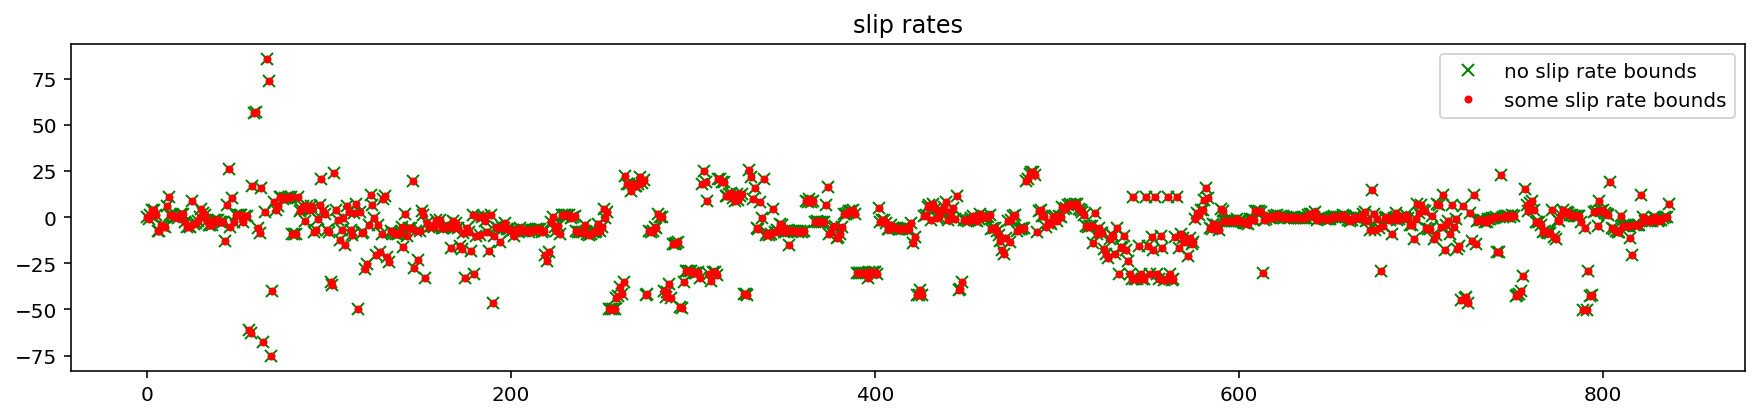

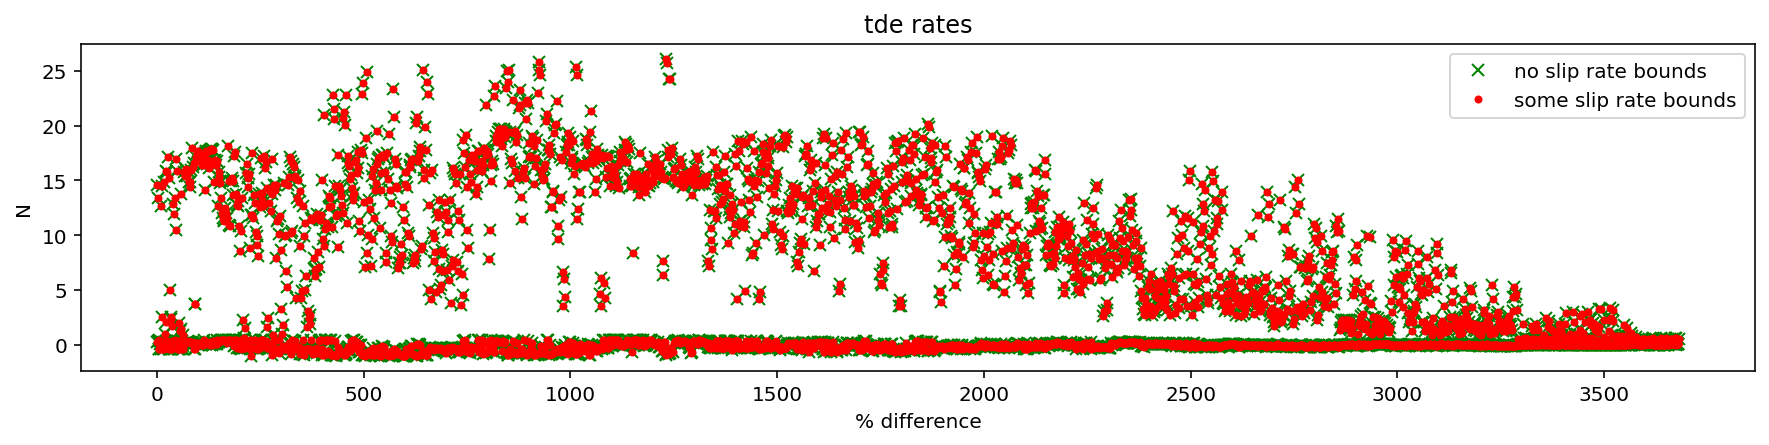

In [13]:
for i in range(len(bound_fault_idx)):
    print(
        f"""segment index : {bound_fault_idx[i]},
        No bounds: {estimation_ref.strike_slip_rates[bound_fault_idx[i]]:0.3f},
        Upper and lower bounds: {estimation_fun.strike_slip_rates[bound_fault_idx[i]]:0.3f}"""
    )

plt.figure(figsize=(15, 3))
plt.plot(estimation_ref.strike_slip_rates, "gx", label="no slip rate bounds")
plt.plot(estimation_fun.strike_slip_rates, "r.", label="some slip rate bounds")
plt.legend()
for i in range(len(bound_fault_idx)):
    plt.axvline(bound_fault_idx[i])
plt.title("slip rates")
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(estimation_ref.tde_rates, "gx", label="no slip rate bounds")
plt.plot(estimation_fun.tde_rates, "r.", label="some slip rate bounds")
plt.legend()
plt.xlabel("% difference")
plt.ylabel("N")
plt.title("tde rates")
plt.show()

In [14]:
# TODO: QP test on three mesh Japan
# TODO: QP constraints parameters to segment file
# TODO: qp_tde_inequality_matrix to operators
# TODO: Move all functions to one cell at top
# TODO: Find `: :`
# TODO: Some sort of segment file checker that makes sure mins are less than maxs and that there aren't soft and hard constraitns on the same elements?

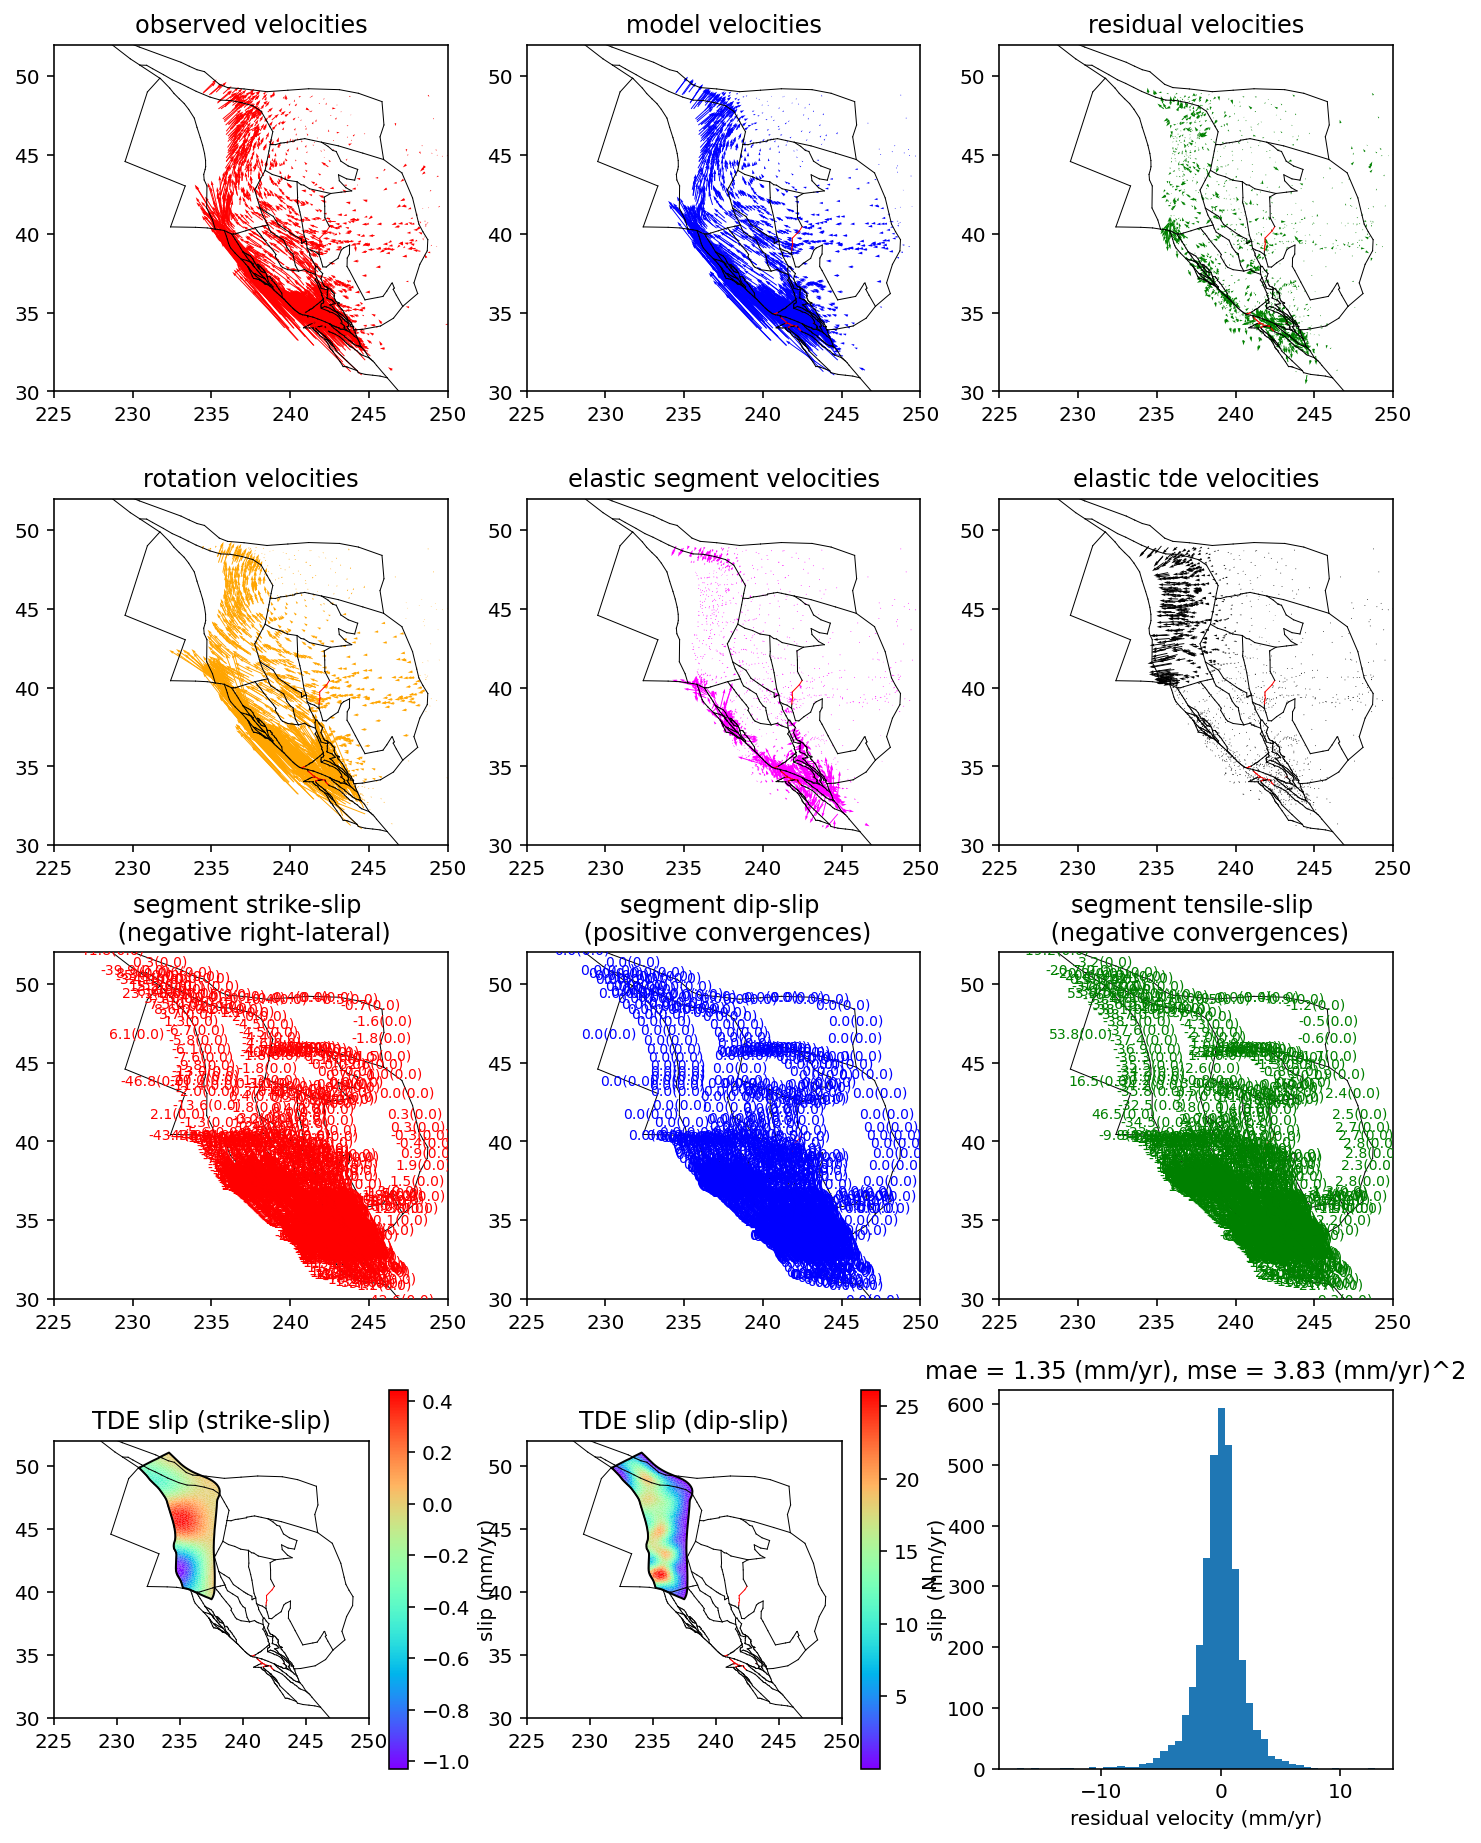

2024-08-13 16:11:21.010 | SUCCESS  | celeri.celeri:plot_estimation_summary:5601 - Wrote figures../runs/0000000201/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [15]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_ref,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

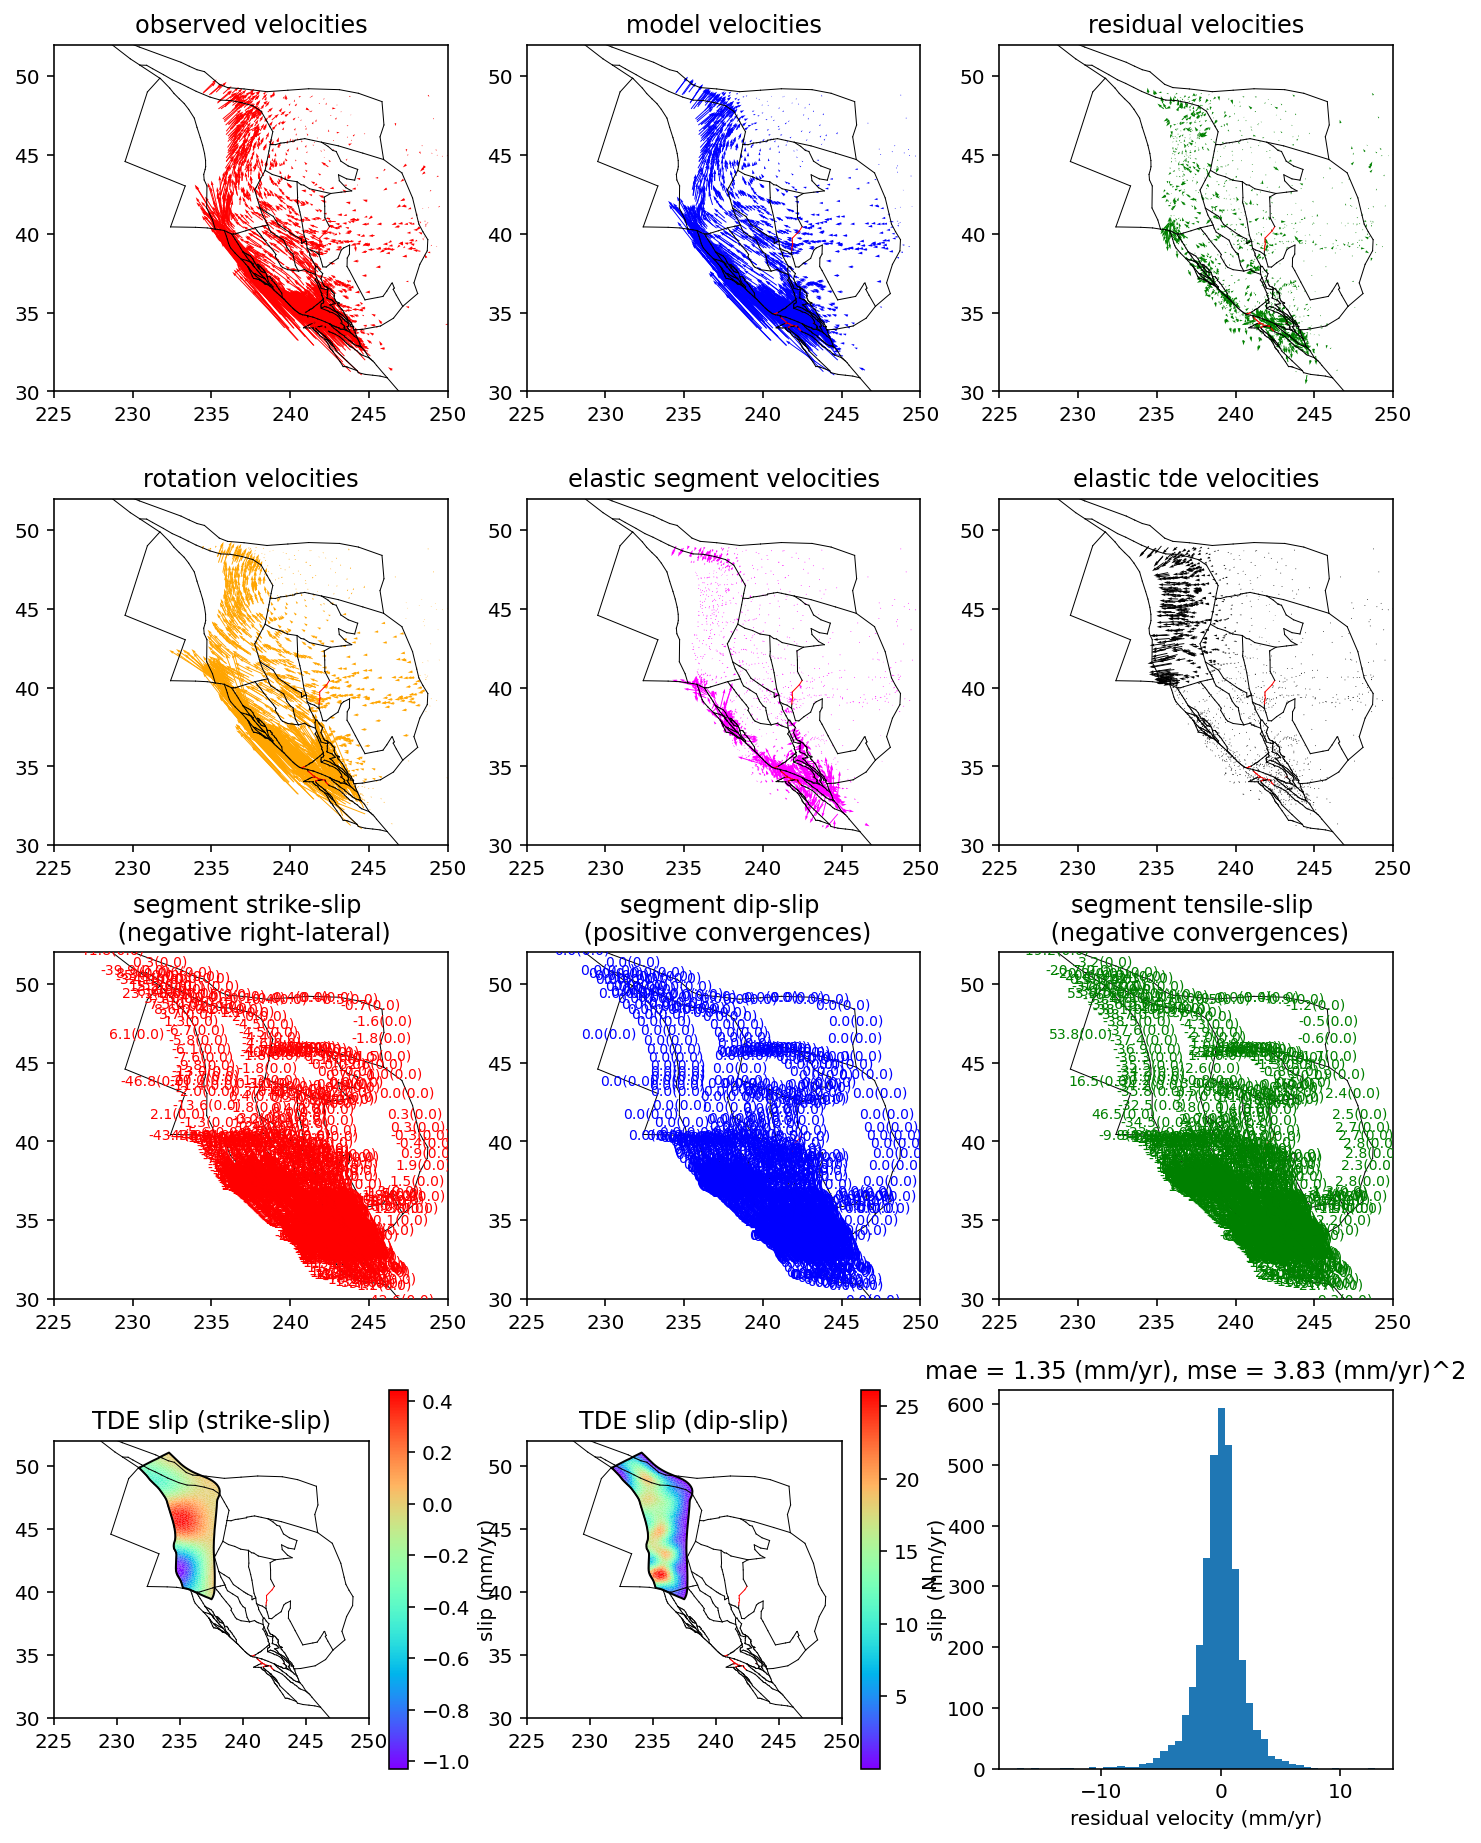

2024-08-13 16:11:28.424 | SUCCESS  | celeri.celeri:plot_estimation_summary:5601 - Wrote figures../runs/0000000201/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [16]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_fun,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)